# Assignment 4

## André Dias (59452); Tiago Rodrigues (49593)

## Problem 2

### a) Make a model with all parameters known

In [1]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn import hmm

For problem a) and b), it is intended to use the rolls and dices provided in the assignment pdf. Futhermore, the last 10 rolls should be used for model testing. As such, the initial step will be to transform the data into a usable format, such as numpy arrays.

In [2]:
# Create a string with the rolls in the pdf
text_rolls = '664153216162115234653214356634261655234232315142464156663246'

# Create an array encompassing every element in the string, while converting it to integer and subtracting 1, since python starts at 0
# As such, possible rolls will be: 0, 1, 2, 3, 4, 5
rolls = np.array([[int(i)] for i in text_rolls]) - 1

# Divide the array into a train and test set (test set = last 10 elements, train test is every element up to the last 10)
rolls_test = rolls[-10:]
rolls_train = rolls[:len(rolls)-10]


# Create a string with the rolls in the pdf
dice_text = 'LLLLLLLLLLLLLLFFFFFFLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFLLLLLLLL'

# Codify the dices into binary 0 or 1 to make graphical representations easier
dice_text = dice_text.replace('F', '0').replace('L', '1')

# Create an array encompassing every element in the string
dices = np.array([i for i in dice_text])

# Divide the array into a train and test set (test set = last 10 elements, train test is every element up to the last 10)
dices_test = dices[-10:]
dices_train = dices[:len(rolls)-10]

In the first problem, it is assumed that all parameters are known. As such, the following parameters must be provided: number of states, number of features,  transition matrix, emission matrix and starting probabilities.

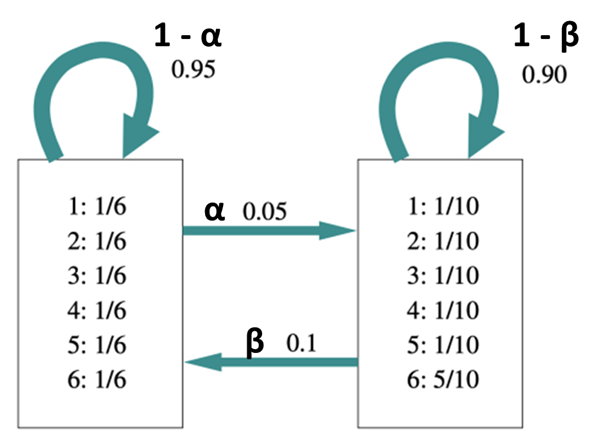

The number of states in this casino problem corresponds to the two different dices that exist (the fair dice and the loaded dice). As such, there are a total of 2 states.

The number of features corresponds to the total number of distinct values that the dices can have. In the dices of the problem, it can take values of 1, 2, 3, 4, 5 or 6. As such, there are a total of 6 features.

The transition matrix corresponds to the probability of a state changing to another or to himself in the next step. In this case, this corresponds to the probability of the dice being switched to the other one or staying in play. As such, this matrix will be n x n, where n is the number of states that exist. In this case, we will have a 2 by 2 matrix, which will be represented using 1 by 2 arrays, indicating the possibility of each dice staying in play or changing to the other dice in the next roll.

The emission matrix corresponds to the probabilities of the occurence of each of the features. Each state has its own probabilities, leading to a matrix that is n x m, where n is the number of states and m is the number of features. In this case, this relates to the probability of each dice face occuring, which is the same for all faces in the fair dice but not the same in the loaded one. The matrix will be 2 by 6, which will be represented using 1 by 6 arrays, indicating the possibility of each dice face to occur in respect to the dice itself (fair or loaded).

Regarding the starting probabilities, they infer the initial probabilities of starting in any of the 2 beforementioned states, meaning that it chooses what dice is firstly chosen (fair or loaded). When these are not known, as in this case, some options are available: (1) choose equal probability for all states (0.5 in this case, as there are 2 states); (2) choose random probabilities; (3) compute a starting probability based on the transition probabilities, as seen below:

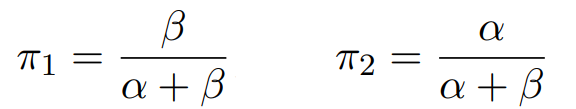

In this formula, alpha corresponds to the probability of the fair dice being changed to the loaded dice and beta corresponds to the probability of the loaded dice being changed to the fair dice. This way of computing the starting probabilities will be used.

With all of this in mind, the model with all parameters can be constructed. Another aspect to keep in mind is that, since the probabilities of this problem are not continuous, a gaussian hidden markov model should not be used, in favor of other ones. In the assignment, it is sugested to use the Categorical HMM. Lastly, since the model will be given all the problem's parameters, no model training is required.

In [3]:
# Calculate the starting probabilities of each dice
start_prob_fair = (0.1)/(0.05 + 0.1)
start_prob_loaded = (0.05)/(0.05 + 0.1)

# Create the model with the beforementioned number of states
model_all_params = hmm.CategoricalHMM(n_components = 2, random_state = 2023)

# Provide all the model parameters
model_all_params.n_features = 6
model_all_params.startprob_ = np.array([start_prob_fair, start_prob_loaded])
model_all_params.transmat_ = np.array([[0.95, 0.05],[0.1, 0.9]])
model_all_params.emissionprob_ = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6], [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]])

# Obtain the log likelihood of the model with all parameters on the test set of the rolls
print('The log likelihood of the model with all parameters is:', model_all_params.score(rolls_test))

The log likelihood of the model with all parameters is: -16.98461390418157


The log likelihood is a scoring measure that indicates how well the model fits the data (in this case the model was not trained because all parameters were given, but the score is still indicative of how good it is). The higher the score, the better the model, but it is important to only compare models using the same sample, as sample size severely impacts the score. Some models obtain a better log likelihood as the sample size increases but it can also lead to worse scores when the data is complex and the model struggles to capture all variations in the data. Nevertheless, it is not solely indicative that the model is bad and should be used in conjunction with other metrics if the goal is to evaluate how good a model is.

### b) Make a model whose transition matrix is estimated

In this exercise, it is intended to make the same procedure as before, but this time not provide the transition matrix and allow the model to estimate it. In this case, since the model does not have all the parameters, it needs to be trained using all the rolls up until the last ten (rolls_train). Furthermore, since the transition matrix estimation is not the same everytime a model is created, a total of 50 different fits will be tested. 

There are some key aspects that are really important in this problem: 

(1) since the transition matrix is not given, it must be estimated, which is achieved by using the "init_params" parameter and telling the model to estimate the transition matrix, represented by "t". 

(2) the number of iterations that the model does to try and reach convergence of the log likelihood is given by the parameter "n_iter". The model uses the expectation maximization algorithm to estimate the desired parameters (transition matrix in this case), which should reach convergence after a given amount of cicles. Since the default value is really small (only 10 iterations), this number must be increased to allow convergence of the model. 

(3) on the other hand, the indication of a model convergence is given by the "tol" parameter, which indicates the value that the difference between the log likelihood of two iterations must achieve to dictate convergence. The default value is 0.01, but this was changed to 0.001. It's important to note that if convergence is reached before the defined number of iterations, the algorithm will stop at that iteration and not waste time and resources.

With this in mind, the best model of the 50 fits will be the only one kept in end. It's score and transition matrix will then be compared to the model with all parameters. Lastly, the dice states over the last ten rolls will be estimated using this best model and these will be plotted against the true dice states, given in the pdf.

The log likelihood of the model with all parameters is: -16.98461390418157
The log likelihood of the best model is: -17.400957264319366

Model with all parameters transition matrix:
 [[0.95 0.05]
 [0.1  0.9 ]]
Best model transition matrix:
 [[0.    1.   ]
 [0.778 0.222]]


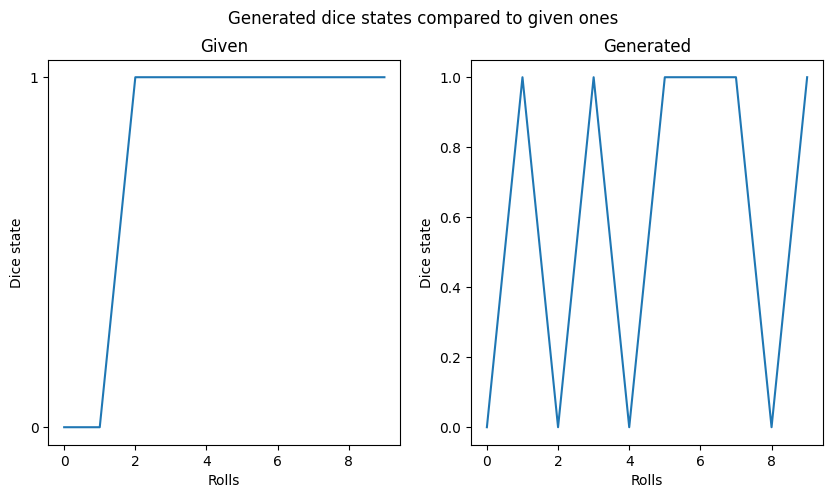

In [4]:
# Fit a total of 50 models with different random states and save the best one
best_score = best_model = None
n_fits = 50
np.random.seed(13)
for idx in range(n_fits):
    # Create the model but this time give init_params (to estimate the transition matrix) and n_iter and tol to define convergence
    model = hmm.CategoricalHMM(n_components = 2, random_state = idx, init_params = 't', n_iter = 1000, tol = 0.001)
    model.n_features = 6
    model.startprob_ = np.array([start_prob_fair, start_prob_loaded])
    model.emissionprob_ = np.array([[1/6, 1/6, 1/6, 1/6, 1/6, 1/6], [1/10, 1/10, 1/10, 1/10, 1/10, 1/2]])
    # Train the model on the rolls_train data to allow the model to estimate the transition matrix
    model.fit(rolls_train)
    # Obtain log likelihood of the model
    score = model.score(rolls_test)
    # Only save the best model
    if best_score is None or score > best_score:
        best_model = model
        best_score = score


def ScoreTransition(model_all_params, best_score, emission = False):
    # Compare the score of the model with all parameters and the best model calculated without all parameters
    original_score = model_all_params.score(rolls_test)
    print(f'The log likelihood of the model with all parameters is: {original_score}\nThe log likelihood of the best model is: {best_score}')

    # Compare the transition matrixes of the model with all parameters and the best model calculated without all parameters
    print('\nModel with all parameters transition matrix:\n', model_all_params.transmat_)
    print('Best model transition matrix:\n', best_model.transmat_.round(3))

    if emission == True:
        # Compare the emission matrixes of the model with all parameters and the best model calculated without all parameters
        print('\nModel with all parameters emission matrix:\n', model_all_params.emissionprob_)
        print('Best model emission matrix:\n', best_model.emissionprob_.round(3))
    
ScoreTransition(model_all_params, best_score)


def plotDiceStates (dices_test, rolls_test, best_model):
    # Compute the dices states of the model with all parameters and the best model calculated without all parameters
    original_states = dices_test
    best_states = np.array(best_model.predict(rolls_test))
    
    # Plot the known dice states with the generated ones
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,5))
    fig.suptitle('Generated dice states compared to given ones')
    ax1.plot(original_states, label = 'Given')
    ax1.set_title('Given')
    ax1.set_xlabel('Rolls')
    ax1.set_ylabel('Dice state')
    ax2.plot(best_states, label = 'Generated')
    ax2.set_title('Generated')
    ax2.set_xlabel('Rolls')
    ax2.set_ylabel('Dice state')

plotDiceStates(dices_test, rolls_test, best_model)

As seen by the log likelihoods of the two models, the one of the best model, obtained when the transition matrix was estimated, was slightly lower than the log likelihood of the model for which all the parameters were known, which indicates that the best model is slightly worse.

Regarding the transition matrixes, it's possible to see that the estimated transition matrix of the best model is different from the transition matrix of the model for which all parameters were known. Two main points can be made: (1) the transition matrix is basically inverted, being more likely to transition to another state than remaining in the same state; (2) even then, there are significant differences in the values of the transitions when this is taken into account. This is indicative that the estimation of this matrix was not good, which may partially be due to the small dataset used for training the model (roughly only 50 points).

Lastly, when looking at the plot of dice states over the test rolls, clear differences can be seen, as in the given states, the current state tends to stay the same over the number of rolls while the ones generated using the best model almost always change in each step, which is in line with the results seen in its transition matrix. In the best model, when the 0 state is reached, the transition matrix indicates that the state will always change to 1 in the next step. On the other hand, when the 1 state is reached, the transition matrix indicates that the state will change to 0 in 77.8 % of the cases. This explains why in the generated states the state changes almost in every step.

### c) Using the rolls and dices txt file:

#### c i.) Make a model whose transition and emisson matrixes are estimated

The first step in the problem is to read the text files with the rolls and dice states. These dataframes have to then be coverted to a usable format, similarly to what was done in the previous problems:

In [5]:
# Read the rolls.txt file into a dataframe, indicate that there is no header so it does not remove 1 roll.
# Then create an array and divide it into a train and test set, similarly to the previous problems.
rolls_text = pd.read_csv('rolls.txt', header = None)
rolls = np.array([[int(i)] for i in np.array(rolls_text)]) - 1
rolls_train = rolls[:round((len(rolls)/2))]
rolls_test = rolls[round((len(rolls)/2)):]


# Read the dice.txt file into a dataframe, indicate that there is no header so it does not remove 1 dice state.
# Then create an array, codify the states and divide it into a train and test set, similarly to the previous problems.
dices_text = pd.read_csv('dice.txt', header = None)
dices_text = np.array(dices_text.replace('F', '0').replace('L', '1'))
dices = np.array([int(i) for i in dices_text])
dices_train = dices[:round(len(dices)/2)]
dices_test = dices[round(len(dices)/2):]

Following this and similarly to the previous exercise, 50 different fits are tested and now the emission matrix is also estimated and not given. As such, the "init_params" are "te" (corresponding to transmission and emission matrixes).

The log likelihood of the model with all parameters is: -961.6460620989014
The log likelihood of the best model is: -961.9920239058436

Model with all parameters transition matrix:
 [[0.95 0.05]
 [0.1  0.9 ]]
Best model transition matrix:
 [[0.967 0.033]
 [0.023 0.977]]

Model with all parameters emission matrix:
 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]
Best model emission matrix:
 [[0.119 0.113 0.075 0.098 0.149 0.446]
 [0.167 0.122 0.187 0.162 0.149 0.213]]


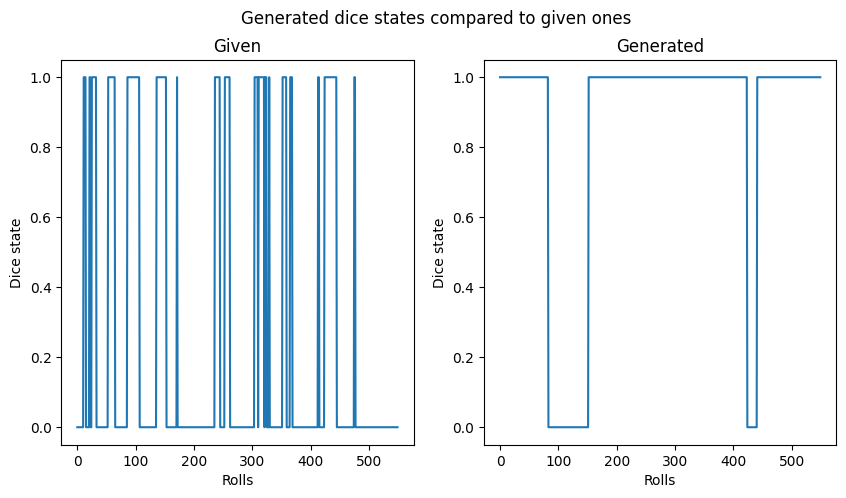

In [6]:
best_score = best_model = None
n_fits = 50
np.random.seed(13)
for idx in range(n_fits):
    # Now init_params has not only t, but an e aswell, indicative that the emision matrix will also be estimated
    model = hmm.CategoricalHMM(n_components = 2, random_state = idx, init_params = 'te', n_iter = 1000, tol = 0.001)
    model.n_features = 6
    model.startprob_ = np.array([start_prob_fair, start_prob_loaded])
    model.fit(rolls_train)
    score = model.score(rolls_test)
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

ScoreTransition(model_all_params, best_score, True)

plotDiceStates(dices_test, rolls_test, best_model)

As seen by the log likelihoods of the two models, the one of the best model, obtained when the transition and emission matrixes were estimated, had a slighlty lower log likelihood than the one of the model for which all the parameters were known, which indicates that the best model is slightly worse. When compared to problem b), the difference between them is slightly smaller (from 0.4 to 0.35), but it's important to keep in mind that the relative difference between the models is actually much smaller due to the increased sample size, indicating that the best model is much closer to the model with all parameters. This is indicative that more data will lead to better approximations to the truth model. On top of this, it can be seen that the log likelihoods got smaller, when compared to exercise b), which, as previously mentioned, is a product of the size increase of the test sample.

Regarding the transition matrixes, it's possible to see that the estimated transition matrix of the best model is still different from the transition matrix of the model for which all parameters were known. Regardless, in this case, the transition matrix is no longer inverted and its much closer between both models. Despite this, some notable differences are still seen in the transition matrix, where the transition probability from state 1 to 0 is much lower (from 0.1 to 0.023).

Regarding the emission matrixes, some clear differences can be seen: (1) the emission of state 0 of the best model seems to be more in line with the emission of state 1 of the model with all parameters and vice versa; (2) when this is taken into consideration, the values seen are actually fairly decent approximations, with some being really close and others slighly worse but still on the right track.

Lastly, when looking at the plot of dice states over the test rolls, clear differences can be seen, as in the given states, the current state tends to differ over the number of rolls while in the ones generated using the best model, the current state almost never changes, which is in line with the results seen in its transition matrix. In the best model, when the 0 state is reached, the transition matrix indicates that the state will change to 1 in 3.3 % of the cases (instead of 5% for the model with all parameters). On the other hand, when the 1 state is reached, the transition matrix indicates that the state will change to 0 in 2.3 % of the cases (instead of 10 % for the model with all parameters). This explains why in the generated states the state almost never changes.

Overall, using more data to train the model led to better approximations to the real system, even when estimating one more parameter.

#### c ii.) Make a model whose parameters are all estimated

In this case, no parameters are given to the model and they must be estimated by the model itself. As such, on top of the parameters not given in the last model, the number of parameters, starting probabilities and, most importantly, the number of states are also not given. Since the number of states is required to create a model, varying number of states, ranging from 1 to 4 were tested, as per suggestion of the assignment.

The log likelihood of the model with all parameters is: -961.6460620989014
The log likelihood of the best model is: -960.6571677843808

Model with all parameters transition matrix:
 [[0.95 0.05]
 [0.1  0.9 ]]
Best model transition matrix:
 [[0.96  0.    0.04 ]
 [0.032 0.793 0.174]
 [0.001 0.825 0.174]]

Model with all parameters emission matrix:
 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]
Best model emission matrix:
 [[0.119 0.109 0.063 0.096 0.153 0.459]
 [0.206 0.155 0.039 0.198 0.15  0.253]
 [0.004 0.001 0.809 0.017 0.136 0.034]]


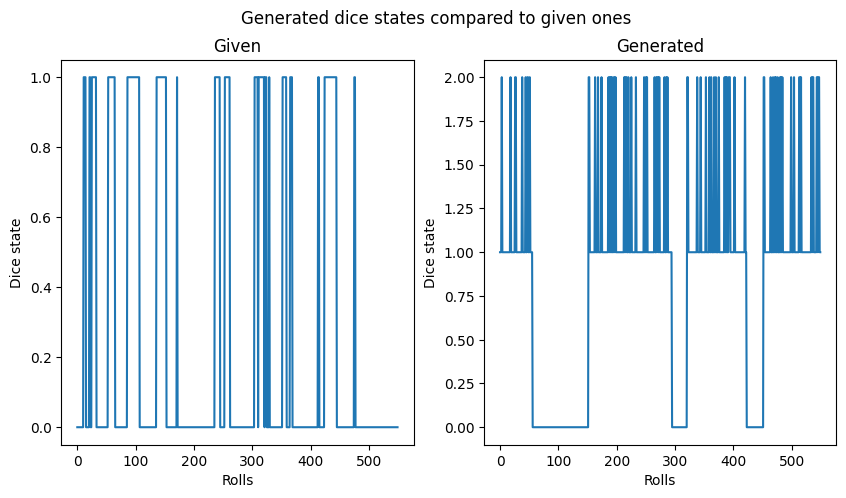

In [7]:
best_score = best_model = None
n_fits = 50
np.random.seed(13)
# This for loop serves to iterate over distinct number of states
for i in range(1,5):
    for idx in range(n_fits):
        # In this case, n_components is equal to the i we are iterating over and init_params also has an s (estimation of starting prob)
        model = hmm.CategoricalHMM(n_components = i, random_state = idx, init_params = 'ste', n_iter = 1000, tol = 0.001)
        model.fit(rolls_train)
        score = model.score(rolls_test)
        if best_score is None or score > best_score:
            best_model = model
            best_score = score

ScoreTransition(model_all_params, best_score, True)
            
plotDiceStates(dices_test, rolls_test, best_model)

As seen by the log likelihoods of the two models, the one of the best model, obtained when the all parameters were estimated, had a slighlty higher log likelihood than the one of the model for which all the parameters were known, which indicates that the best model should be slightly better.

Regarding the transition matrixes, it's possible to see that the estimated transition matrix of the best model is now very different from the transition matrix of the model for which all parameters were known, since a total of 3 states are now considered instead of 2. This is indicative that when the model is left to estimate everything, an incorrect number of states may provide a better model score than the true number of states. Nevertheless, the transition probabilities of the 0 state are very similar to the model with all parameters.

Regarding the emission matrixes, the same conclusion seen in the transition matrixes apply, with the emission matrix of the best model now having 3 rows, due to the 3 possible states. To note that the first row of the emission matrix of the best model is very similar to the second row of the emission matrix of the models with all parameters, indicating that the state 0 is actually the state 1 of the original model.

Lastly, when looking at the plot of dice states over the test rolls, clear differences can be seen, as the best model has three states instead of two.

Overall, when the model is left to estimate everything some significant mistakes can be made, especially regarding the number of states in the system.

### d) Make the same procedure as c) using the model in a) to make a 30000 points dataset

#### d i.) Make a model whose transmission and emisson matrix are estimated

The initial step in this problem is to generate a dataset of 30000 points using the model created in a). These rolls and dice data have to then be divided into training and testing.

In [8]:
# Generate a sample of 30000 using the model in a)
rolls, dices = model_all_params.sample(30000)

# Divide rolls into train and test
rolls_train = rolls[:round(len(rolls)/2)].copy()
rolls_test = rolls[round(len(rolls)/2):].copy()

# Divide dices into train and test
dices_train = dices[:round(len(dices)/2)].copy()
dices_test = dices[round(len(dices)/2):].copy()

In [9]:
best_score = best_model = None
n_fits = 50
np.random.seed(13)
for idx in range(n_fits):
    model = hmm.CategoricalHMM(n_components = 2, random_state = idx, init_params = 'te', n_iter = 1000, tol = 0.001)
    model.n_features = 6
    model.startprob_ = np.array([start_prob_fair, start_prob_loaded])
    model.fit(rolls_train)
    score = model.score(rolls_test)
    if best_score is None or score > best_score:
        best_model = model
        best_score = score

ScoreTransition(model_all_params, best_score, True)

The log likelihood of the model with all parameters is: -26159.12263041461
The log likelihood of the best model is: -26161.230758050086

Model with all parameters transition matrix:
 [[0.95 0.05]
 [0.1  0.9 ]]
Best model transition matrix:
 [[0.882 0.118]
 [0.059 0.941]]

Model with all parameters emission matrix:
 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]
Best model emission matrix:
 [[0.097 0.1   0.1   0.105 0.107 0.491]
 [0.169 0.166 0.162 0.169 0.17  0.164]]


As seen by the log likelihoods of the two models, the one of the best model, obtained when the transition matrix was estimated, had a slighlty lower log likelihood than the one of the model for which all the parameters were known, which indicates that the best model is slightly worse. Despite the difference between scores being slightly higher than previously, the relative difference between the models is actually smaller given the much bigger dataset, indicating that the best model is closer to the model with all parameters. Similarly to before, this is indicative that more data will lead to better approximations to real life.

Regarding the transition matrixes, it's possible to see that the estimated transition matrix of the best model is inverted from the model with all parameters, as the 0 state of the best model seems to correspond to the 1 state of the model with all parameters. When this is considered, the transitions matrixes are actually very similar, once again indicating that more data leads to better approximations.

Regarding the emission matrixes, the same conclusions made for the transition matrixes apply.

Overall, using more data to train the model led to better approximations to the real system.

#### d ii.) Make a model whose parameters are all estimated

In [10]:
best_score = best_model = None
n_fits = 50
np.random.seed(13)
for i in range(1,5):
    for idx in range(n_fits):
        model = hmm.CategoricalHMM(n_components = i, random_state = idx, init_params = 'ste', n_iter = 1000, tol = 0.001)
        model.fit(rolls_train)
        score = model.score(rolls_test)
        if best_score is None or score > best_score:
            best_model = model
            best_score = score
            
ScoreTransition(model_all_params, best_score, True)

The log likelihood of the model with all parameters is: -26159.12263041461
The log likelihood of the best model is: -26161.243353399463

Model with all parameters transition matrix:
 [[0.95 0.05]
 [0.1  0.9 ]]
Best model transition matrix:
 [[0.941 0.059]
 [0.118 0.882]]

Model with all parameters emission matrix:
 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]
Best model emission matrix:
 [[0.169 0.166 0.162 0.169 0.17  0.164]
 [0.097 0.1   0.1   0.105 0.107 0.491]]


As seen by results obtained, the best model obtained is very similar to the one with all the parameters and very similar to the previous one, where only the transition and emission matrixes were estimated.

Unlike in c), where the model with basically everything unknown led to weird results with 3 states, when the amount of data to train the model was increased, the model became more accurate with only 2 states.

Both the transmission and emission matrixes are extremely close to the model with all parameters.

Overall, the increase in data for training led to a much more robust model, which could even overcome not being given the number of states of the model, which had yielded innacurate results when the volume of data to train was smaller.

As such, for hidden markov models, more data the merrier, leading to better approximations to the real systems.